# Machine Learning - Text Classification

This notebook implements and experiments with different classifiers to perform text classification on the 20 Newsgroups data set, a collection of approximately 20,000 newsgroup documents that are partitioned (nearly) evenly across 20 different newsgroups.

The Logistic Regression and Naive Bayes classifiers are implemented and the following configurations are explored:
* Feature selection methods to obtain the feature set
* Feature Encoding (binary encodings or term-freqency encodings)
* Amount of features
* Hyperparameters such as regularization




## Setup

In [ ]:
%%capture
!pip install wget

In [ ]:
from abc import abstractmethod, ABC
import os
import wget
from pathlib import Path

from nltk.tokenize import RegexpTokenizer
import re
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, _BaseNB, _BaseDiscreteNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed()
from typing import Tuple, List, Optional, Union, Dict

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Please add necessary imports here
import nltk
from nltk.corpus import stopwords
from nltk.stem import *


nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
%%capture
filename = wget.download("https://github.com/MIE451-1513-2023/course-datasets/raw/main/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip

In [ ]:
## IMPORTANT: DO NOT CHANGE THESE GLOBAL VARIABLES!
DATA_DIR = "20_newsgroups"
ALL_FILES = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [ ]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    new_text = re.sub("Lines:.*?\n", "", new_text)
    new_text = re.sub("Reply-To:.*?\n", "", new_text)
    new_text = re.sub("Message-ID:.*?\n", "", new_text)
    new_text = re.sub("From:.*?\n", "", new_text)
    new_text = re.sub("NNTP-Posting-Host:.*?\n", "", new_text)
    return new_text

In [ ]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r"\w+")
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [ ]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ["talk.politics.mideast", "rec.autos", "comp.sys.mac.hardware", "alt.atheism", "rec.sport.baseball",
     "comp.os.ms-windows.misc", "rec.sport.hockey", "sci.crypt", "sci.med", "talk.politics.misc",
     "rec.motorcycles", "comp.windows.x", "comp.graphics", "comp.sys.ibm.pc.hardware", "sci.electronics",
     "talk.politics.guns", "sci.space", "soc.religion.christian", "misc.forsale", "talk.religion.misc"]
    return topics.index(topic_name)

In [ ]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)

    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Classifier Class

In [ ]:
class Classifier(ABC):
    """
    Defines the super class that all classifier classes have to inherit.
    This class requires one argument 'model_cls' which should be the sklearn classfication algorithm class.
    For example, 'LogisticRegression' or 'MultinomialNB' can be used.
    """
    _X, _y = None, None      # Class variables that store features and labels

    def __init__(self, model_cls):
        self._model_cls = model_cls

    @abstractmethod
    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This is an abstract method which has to be implemented in subclasses.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        pass

    def train_and_predict(
            self, file_list=None, X=None, y=None, test_size=0.3, random_state=22, **model_kwargs
    ) -> Tuple[Dict, Dict]:
        """
        Complete this method for Q1(b).

        This method (1) constructs the dataset; (2) splits it into train/test sets;
        (3) trains a multi-class classifier model with the type 'self._model_cls';
        (4) evaluates the trained model with the test set;
        (5) and finally returns the dataset and accuracy information as dictionaries.

        """
        # This method can also be used with an already-built dataset (X, y)
        if file_list is None:
            assert X is not None and y is not None, "Either 'file_list' or (X, y) should be provided"

        # Get the dataset (features and labels) if not provided
        if X is None or y is None:
            X, y = self.get_dataset(file_list)

        # Split the dataset to train and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Train a classifier of type 'self._model_cls' using the train set.
        clf = self._model_cls(**model_kwargs).fit(X_train, y_train)

        # Make predictions with the train and test sets
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # Calculate the train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # Values to return
        dataset = dict(
            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
        )
        info = dict(
            y_train_predict=y_train_predict, y_test_predict=y_test_predict,
            train_accuracy=train_accuracy, test_accuracy=test_accuracy
        )

        # Validate return types
        assert isinstance(train_accuracy, float) and isinstance(test_accuracy, float), "incorrect return types"
        assert isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame), "incorrect return types"
        assert isinstance(y_train, list) and isinstance(y_test, list), "incorrect return types"
        assert isinstance(y_train_predict, np.ndarray) and isinstance(y_test_predict, np.ndarray), "incorrect return types"

        return dataset, info

    @staticmethod
    def get_performance_ci(
            classifier, X=None, y=None, num_tests=10, test_size=0.3, file_list=None
    ) -> Tuple[float, float, float, float, float, float]:
        if X is None or y is None:
            assert file_list is not None, "When X/y is not passed, you should provide 'file_list'"
            X, y = classifier.get_dataset(file_list)

        # 'train_results' is a list of train accuracy for differrent random splits of the dataset
        train_results = []

        # 'test_results' is a list of test accuracy for differrent random splits of the dataset
        test_results = []

        # Get random states for different splits
        random_states = np.random.permutation(range(1000))[:num_tests]

        # Get accuracy results for each split
        for random_state in random_states:
            dataset, info = classifier.train_and_predict(X=X, y=y, random_state=random_state)
            train_results.append(info['train_accuracy'])
            test_results.append(info['test_accuracy'])

        # Calculate the train mean and the 95% confidence interval for the list of results
        train_mean = np.mean(train_results)
        train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))

        # Calculate the test mean and the 95% confidence interval for the list of results
        test_mean = np.mean(test_results)
        test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))

        # Validate return types
        assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
        assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"

        return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

    @staticmethod
    def create_cm(
            classifier, X: pd.DataFrame, y: List[int], num_tests: int, test_size=0.3
    ) -> np.ndarray:
        # 'cm_list' should contain the confusion matrices for different random splits of the dataset
        cm_list = []

        # Get random states for different splits
        random_states = np.random.permutation(range(1000))[:num_tests]

        # Get confusion matrix for each split
        for random_state in random_states:
            dataset, info = classifier.train_and_predict(X=X, y=y, random_state=random_state)
            cm_list.append(confusion_matrix(dataset['y_test'], info['y_test_predict']))

        # Sum the confusion matrices and return the combined confusion matrix
        combined_cm = np.array(cm_list).sum(axis=0)

        # validate return type
        assert isinstance(combined_cm, np.ndarray), "return type"

        return combined_cm

    @property
    @abstractmethod
    def X(self):
        pass

    @property
    @abstractmethod
    def y(self):
        pass

    @X.setter
    @abstractmethod
    def X(self, X):
        pass

    @y.setter
    @abstractmethod
    def y(self, y):
        pass

## Binary Encodings

In [ ]:
print(len(ALL_FILES))

19997


The feature set is constructed based on the most common words in the corpus. It does this by taking the word count of all the words in the corpus and then selecting the ones that appear the most frequently. Then for each file, we check if the word in the feature set appears in the file (it would be encoded as a 1 and if not, it would be encoded as a 0). This would be how each file is encoded in the feature set. The label y is encoded as the index of the topic as it appears in the get_target() function.

The dataset consists of 19997 files and the default number of words used in the feature set is 1000. Therefore size of the features X is (19997, 1000) and size of the labels y is (19997, 1)


### Classifier with Binary Encoding

In [ ]:
class ClassifierWithBinaryEncoding(Classifier):

    _X, _y = None, None

    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the binary encoding for features, where the most common
        'num_words' number of terms are used.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        # Calculate word count in corpus
        news_cnt = corpus_count_words(file_list)

        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

        # Create a binary encoding of dataset based on the selected features (X)
        tokenizer = RegexpTokenizer(r"\w+")
        df_rows = []
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                df_rows.append([1 if word in file_words else 0 for word in word_list])
        X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns=word_list)

        # Create a dataframe of targets (y)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        self.X = X; self.y = y

        return X, y

    @property
    def X(self):
        return ClassifierWithBinaryEncoding._X

    @property
    def y(self):
        return ClassifierWithBinaryEncoding._y

    @X.setter
    def X(self, X):
        ClassifierWithBinaryEncoding._X = X

    @y.setter
    def y(self, y):
        ClassifierWithBinaryEncoding._y = y

In [ ]:
# Instantiate the classifier
q1_b = ClassifierWithBinaryEncoding(model_cls=LogisticRegression)

# Construct the dataset and train the classifier
X_base, y = q1_b.get_dataset(file_list=ALL_FILES)
q1_b_dataset, q1_b_info = q1_b.train_and_predict(
    X=X_base, y=y, test_size=0.3, random_state=22, C=1.0)

In [ ]:
train_accuracy_q1b = q1_b_info['train_accuracy']
test_accuracy_q1b = q1_b_info['test_accuracy']

# report results
print(f"Train accuracy of the baseline model: {train_accuracy_q1b}")
print(f"Test accuracy of the baseline model: {test_accuracy_q1b}")

Train accuracy of the baseline model: 0.9476316353504323
Test accuracy of the baseline model: 0.6813333333333333


### Classifier with Improved Binary Encoding

Implemented an improved feature set in the *get_dataset* method of the following class.

In [ ]:
class ClassifierWithImprovedBinaryEncoding(ClassifierWithBinaryEncoding):

    _X = None

    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the binary encoding for features, where the most common
        'num_words' number of terms are used. Further, this class should use
        improved features than the one given by its super class.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X = None
        y = self.y      # Could be None if 'ClassifierWithBinaryEncoding.get_dataset()' has not been called

        # Make improvements to the feature set
        tokenizer = RegexpTokenizer(r"\w+")
        stop_words = set(stopwords.words('english'))
        news_cnt = Counter()
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                file_words = [word.lower() for word in file_words if word.lower() not in stop_words]
                file_words = [SnowballStemmer('english').stem(word) for word in file_words]
                news_cnt.update(file_words)

        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

        # Create a binary encoding of dataset based on the selected features (X)
        df_rows = []
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                file_words = [word.lower() for word in file_words if word.lower() not in stop_words]
                file_words = [SnowballStemmer('english').stem(word) for word in file_words]
                df_rows.append([1 if word in file_words else 0 for word in word_list])
        X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns=word_list)

        # Create a dataframe of targets (y)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y

        return X, y

    @property
    def X(self):
        return ClassifierWithImprovedBinaryEncoding._X

    @X.setter
    def X(self, X):
        ClassifierWithImprovedBinaryEncoding._X = X


In [ ]:
# Instantiate the classifier
q1_c = ClassifierWithImprovedBinaryEncoding(LogisticRegression)

# Construct the dataset and train the classifier
X_b_improved, y = q1_c.get_dataset(ALL_FILES, num_words=1000)
q1_c_dataset, q1_c_info = q1_c.train_and_predict(
    X=X_b_improved, y=y, test_size=0.3, random_state=22, C=1.0)

In [ ]:
# Retrieve and report the results
train_accuracy_q1c = q1_c_info['train_accuracy']
test_accuracy_q1c = q1_c_info['test_accuracy']

print(f"Train accuracy of the improved model: {train_accuracy_q1c}")
print(f"Test accuracy of the improved model: {test_accuracy_q1c}")

Train accuracy of the improved model: 0.9604200900192899
Test accuracy of the improved model: 0.7375



The train and test accuracy of the model increased after using the improved feature set.

### Results with 10 random splits

The following code computes the mean accuracy and 95% confidence interval over 10 random splits. The confusion matrix is also shown.

In [ ]:
train_mean_bin, train_low_bin, train_high_bin, test_mean_bin, test_low_bin, test_high_bin = Classifier.get_performance_ci(q1_c, X_b_improved, y, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_bin}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_bin}, {train_high_bin}]")
print(f"Average test accuracy over 10 random splits: {test_mean_bin}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_bin}, {test_high_bin}]")

Average training accuracy over 10 random splits: 0.9606487104379509
Confidence interval for training accuracy over 10 random splits: [0.9597774415198784, 0.9615199793560233]
Average test accuracy over 10 random splits: 0.73835
Confidence interval for test accuracy over 10 random splits: [0.7341763467138873, 0.7425236532861126]


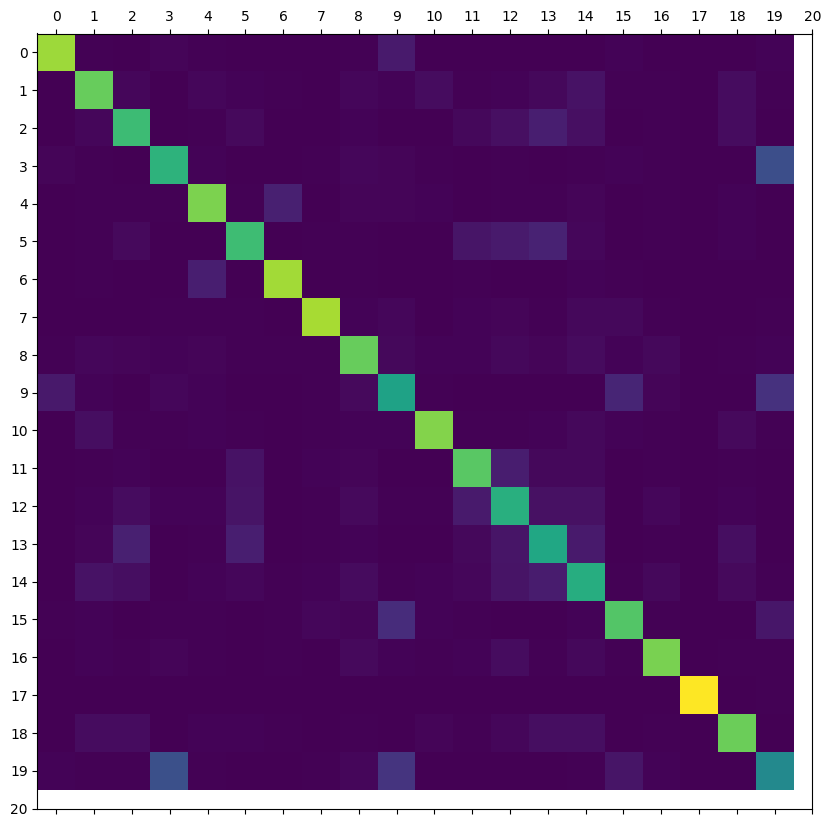

In [ ]:
cm10 = Classifier.create_cm(q1_c, X_b_improved, y, num_tests=10, test_size=0.3)
plot_confusion_matrix(cm10)

From the confusion matrix, we can see that some classes such as alt.atheism and talk.religion.misc are more easily confused. This is because they are very similar/related topics and so would likely have many terms that are very similar so it would be easier to misclassify.

## Experiments Varying the Number of Features

In [ ]:
class ClassifierWithVaryingNumFeatures(ClassifierWithImprovedBinaryEncoding):
    def __init__(self, model_cls):
        super().__init__(
            model_cls=model_cls
        )

    def predict_with_varying_num_features(
            self,
            X: pd.DataFrame,
            y: List[int],
            p_lst: List[float],  # list of percentages of features to use
            test_size=0.3,
            random_state=22
    ) -> pd.DataFrame:
        # 'result_list' is a list of tuples (num_features, train_accuracy, test_accuracy)
        # where 'num_features' is the number of words used as features
        result_list = []

        # Note: only use a single train/test split for this evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        for p in p_lst:
            subset_size = int(p*X.shape[1])
            X_train_subset = X_train.iloc[:, 0:subset_size]
            X_test_subset = X_test.iloc[:, 0:subset_size]

            clf = self._model_cls().fit(X_train_subset, y_train)

            # Make predictions with the train and test sets
            y_train_predict = clf.predict(X_train_subset)
            y_test_predict = clf.predict(X_test_subset)

            train_accuracy = accuracy_score(y_train, y_train_predict)
            test_accuracy = accuracy_score(y_test, y_test_predict)

            # Add to 'result_list'
            result_list.append((p, train_accuracy, test_accuracy))

        # Make a dataframe of the results
        result_df = pd.DataFrame(result_list,
                                 columns=["num_features", "train_accuracy", "test_accuracy"])

        # Validate return type
        assert isinstance(result_df, pd.DataFrame), "return type"

        return result_df


Plot of train and test accuracy for the different feature set sizes

<Axes: xlabel='num_features'>

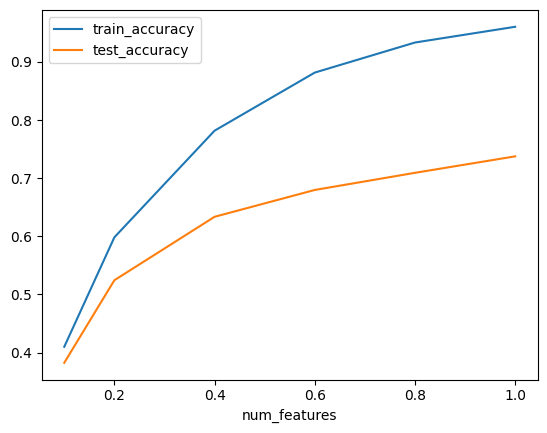

In [ ]:
q2 = ClassifierWithVaryingNumFeatures(LogisticRegression)
p_lst = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
feature_num_df = q2.predict_with_varying_num_features(X_b_improved, y, p_lst)

feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

Generally the accuracy for both the training and testing set improved as there was an increased number of features. However after using around 60% of the features, there was less accuracy improvements on the train and test sets.

## Hyperparameter Tuning

In [ ]:
def hyperparameter(
    classifier: Classifier,
    X: pd.DataFrame,
    y: List[int],
    param_list: List[float],
    test_size: float = 0.3,
    random_state: int = 22,
) -> pd.DataFrame:
    # 'result_list' is a list of tuples (param, train_accuracy, test_accuracy)
    # where 'param' is the hyperparameter value used for training.
    result_list = []

    # Note that this function uses a single train/test split
    # If the trends are not clear, try repeating this for multiple random splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    for param in param_list:
        data, info = classifier.train_and_predict(X=X, y=y, test_size=test_size, random_state=random_state, C=param)
        train_accuracy = info['train_accuracy']
        test_accuracy = info['test_accuracy']

        # Add to result_list
        result_list.append((param, train_accuracy, test_accuracy))

    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])

    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"

    return result_df

In [ ]:
param_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_df = hyperparameter(
    classifier=q1_c,
    X=X_b_improved,
    y=y,
    param_list=param_list,
    test_size=0.3,
    random_state=22,
)

<Axes: xlabel='param'>

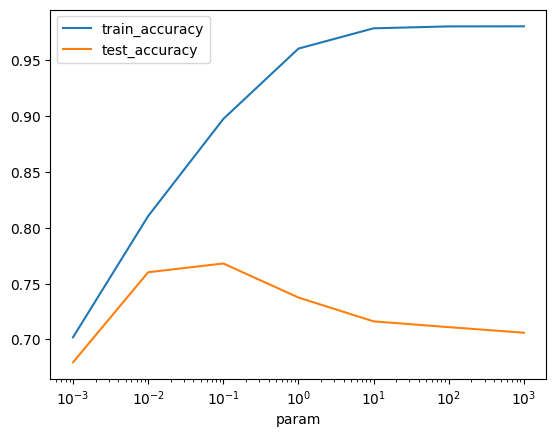

In [ ]:
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

It can be seen that the training accuracy increases as the regularization hyperparameter value increases but the test accuracy decreases after around 0.1 which indicates that the model is starting to overfit due to the weaker regularization.

## Feature Encoding (Term Frequency)

In [ ]:
class ClassifierWithTFEncoding(ClassifierWithBinaryEncoding):

    _X = None

    def __init__(self, model_cls):
        super().__init__(model_cls=model_cls)

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Put your code for Q4(a) here.

        Returns the tuple (X, y) where X is the feature set and y is the label.
        This method uses the term frequency encoding for features, where the most
        common 'num_words' number of terms are used. Further, this class should
        use the improved features from Q1(c) rather than the baseline we provided.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X, y = None, None

        # Use the term frequencies to construct the feature set.
        tokenizer = RegexpTokenizer(r"\w+")
        stop_words = set(stopwords.words('english'))
        news_cnt = Counter()
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                file_words = [word.lower() for word in file_words if word.lower() not in stop_words]
                file_words = [SnowballStemmer('english').stem(word) for word in file_words]
                news_cnt.update(file_words)

        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

        # Create a binary encoding of dataset based on the selected features (X)
        df_rows = []
        for file_path in file_list:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                file_words = [word.lower() for word in file_words if word.lower() not in stop_words]
                file_words = [SnowballStemmer('english').stem(word) for word in file_words]
                file_word_counts = Counter(file_words)
                df_rows.append([file_word_counts[word] if word in file_word_counts else 0 for word in word_list])
        X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns=word_list)

        # Create a dataframe of targets (y)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y
        return X, y

    @property
    def X(self):
        return ClassifierWithTFEncoding._X

    @X.setter
    def X(self, X):
        ClassifierWithTFEncoding._X = X

In [ ]:
q4 = ClassifierWithTFEncoding(LogisticRegression)
X_tf, y_tf = q4.get_dataset(ALL_FILES)

In [ ]:
train_mean_tf, train_low_tf, train_high_tf, test_mean_tf, test_low_tf, test_high_tf = Classifier.get_performance_ci(q4, X_tf, y_tf, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_tf}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_tf}, {train_high_tf}]")
print(f"Average test accuracy over 10 random splits: {test_mean_tf}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_tf}, {test_high_tf}]")

Average training accuracy over 10 random splits: 0.9446167035793385
Confidence interval for training accuracy over 10 random splits: [0.9411931287355693, 0.9480402784231077]
Average test accuracy over 10 random splits: 0.73655
Confidence interval for test accuracy over 10 random splits: [0.7333626726974091, 0.739737327302591]


Comparing the two encodings, the improved binary encodings performed slightly better than the TF encodings. This could be because the binary encodings weigh each term the same regardless of its frequency which can help reduce noise and may have worked better for this dataset as perhaps the term frequency doesn't correlate that well with term importance.

## Comparison with Naive Bayes

In [ ]:
def evaluate_nb(X, y, num_tests) -> Tuple[Classifier, Tuple]:
    train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high = [None] * 6
    nb_classifier =  ClassifierWithImprovedBinaryEncoding(BernoulliNB)
    train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high = Classifier.get_performance_ci(nb_classifier, X, y, num_tests=num_tests)

    # Validate return types
    assert isinstance(nb_classifier, Classifier) and 'NB' in nb_classifier._model_cls.__name__, "incorrect return types"
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "incorrect return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "incorrect return types"

    return nb_classifier, (train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high)

In [ ]:
nb_classifier, (train_mean_nb, train_low_nb, train_high_nb, test_mean_nb, test_low_nb, test_high_nb) = evaluate_nb(X_b_improved, y, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_nb}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_nb}, {train_high_nb}]")
print(f"Average test accuracy over 10 random splits: {test_mean_nb}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_nb}, {test_high_nb}]")

Average training accuracy over 10 random splits: 0.6869543473601486
Confidence interval for training accuracy over 10 random splits: [0.6839837286194864, 0.6899249661008108]
Average test accuracy over 10 random splits: 0.6436333333333334
Confidence interval for test accuracy over 10 random splits: [0.6394489653445344, 0.6478177013221323]


The classifier with logistic regression and improved binary encodings performed better on this dataset than the naive bayes classifier. This is likely because Naive Bayes assumes that features are conditionally independent given the class, which is likely not the case with the frequent words in these documents.

## Binary Logistic Regression

In [ ]:
class BinaryLogisticClassifier(ClassifierWithImprovedBinaryEncoding):

    _y = None

    def __init__(self, model_cls):
        super().__init__(model_cls=model_cls)

    def get_dataset(
            self, file_list, num_words=1000
    ) -> Tuple[pd.DataFrame, List[int]]:
        """
        Put your code for Q6(a) here.

        Returns the tuple (X, y) where X is the feature set and y is the label.
        Use the improved binary encoding from Q1(c) for features, where the most
        common 'num_words' number of terms are used.

        Args:
            file_list (List[int]): The list containing file names to process.
            num_words (int): The number of words (terms) to be used as features
              Note that the feature dataframe you create should have the number
              of columns the same as 'num_words'.

        Returns:
            X (pd.DataFrame), y (List[int])
        """
        if self.X is not None and self.y is not None:
            return self.X, self.y

        X, y = None, None

        X = ClassifierWithImprovedBinaryEncoding._X

        y = [1 if get_topic_name(file_path) == 'sci.med' else 0 for file_path in file_list]

        # Validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "incorrect return types"

        self.X = X; self.y = y
        return X, y

    @property
    def y(self):
        return BinaryLogisticClassifier._y

    @y.setter
    def y(self, y):
        BinaryLogisticClassifier._y = y

In [ ]:
q6 = BinaryLogisticClassifier(LogisticRegression)
X_bin, y_bin = q6.get_dataset(ALL_FILES, num_words=1000)

In [ ]:
train_mean_bin, train_low_bin, train_high_bin, test_mean_bin, test_low_bin, test_high_bin = Classifier.get_performance_ci(q6, X_bin, y_bin, num_tests=10)
print(f"Average training accuracy over 10 random splits: {train_mean_bin}")
print(f"Confidence interval for training accuracy over 10 random splits: [{train_low_bin}, {train_high_bin}]")
print(f"Average test accuracy over 10 random splits: {test_mean_bin}")
print(f"Confidence interval for test accuracy over 10 random splits: [{test_low_bin}, {test_high_bin}]")


Average training accuracy over 10 random splits: 0.9919196970779453
Confidence interval for training accuracy over 10 random splits: [0.9915484460698631, 0.9922909480860274]
Average test accuracy over 10 random splits: 0.9753999999999999
Confidence interval for test accuracy over 10 random splits: [0.9744847241009377, 0.9763152758990622]


Both the average training and test accuracy are really high and the confidence intervals give pretty tight bounds indicating that we can be confident in the averages that we are seeing. From the results we can see that the binary class logistic regression achieved a higher train and test accuracy than the multi-class logistic regression.